<a href="https://colab.research.google.com/github/iskra3138/UDA/blob/main/office31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Mar 18 04:57:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### office31 dataset

In [2]:
!gdown  https://drive.google.com/uc?id=0B4IapRTv9pJ1WGZVd1VDMmhwdlE

Downloading...
From: https://drive.google.com/uc?id=0B4IapRTv9pJ1WGZVd1VDMmhwdlE
To: /content/domain_adaptation_images.tar.gz
77.2MB [00:00, 84.3MB/s]


In [3]:
!tar -xvzf domain_adaptation_images.tar.gz

amazon/images/back_pack/frame_0001.jpg
amazon/images/back_pack/frame_0002.jpg
amazon/images/back_pack/frame_0003.jpg
amazon/images/back_pack/frame_0004.jpg
amazon/images/back_pack/frame_0005.jpg
amazon/images/back_pack/frame_0006.jpg
amazon/images/back_pack/frame_0007.jpg
amazon/images/back_pack/frame_0008.jpg
amazon/images/back_pack/frame_0009.jpg
amazon/images/back_pack/frame_0010.jpg
amazon/images/back_pack/frame_0011.jpg
amazon/images/back_pack/frame_0012.jpg
amazon/images/back_pack/frame_0013.jpg
amazon/images/back_pack/frame_0014.jpg
amazon/images/back_pack/frame_0015.jpg
amazon/images/back_pack/frame_0016.jpg
amazon/images/back_pack/frame_0017.jpg
amazon/images/back_pack/frame_0018.jpg
amazon/images/back_pack/frame_0019.jpg
amazon/images/back_pack/frame_0020.jpg
amazon/images/back_pack/frame_0021.jpg
amazon/images/back_pack/frame_0022.jpg
amazon/images/back_pack/frame_0023.jpg
amazon/images/back_pack/frame_0024.jpg
amazon/images/back_pack/frame_0025.jpg
amazon/images/back_pack/f

In [4]:
# install 'tree' to look at tree structure easily
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (176 kB/s)
Selecting previously unselected package tree.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [5]:
import tensorflow as tf
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

In [6]:
#@title "display utilities [RUN ME!!!]"
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    image *= 255
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(label.numpy().decode("utf-8"), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

In [7]:
# 개별 file로부터 얻고자 하는 정보가 있다면 'read_file_and_label' 함수에 정의합니다.
def read_file_and_label(filename):
  image_bits = tf.io.read_file(filename)## image_bits는 string으로 됩니다.
  
  # parse image name from containing directory
  split_name = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  file_name = split_name.values[-1] ## file_name은 파일명, 즉 string으로 됩니다. (향후 TFRecord 파일 만으로도 이미지의 이름을 알기 위해 추가했습니다.)
  label_name = split_name.values[-2] ## label_name은 폴더명, 즉 string으로 됩니다.
  label = tf.where(np.array(CLASSES)==label_name)[0][0] ## label은 integer가 됩니다.
  
  return image_bits, file_name, label_name, label

In [8]:
# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1

def _bytestring_feature(list_of_bytestrings): # string
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
  

def to_tfrecord(tfrec_filewriter, img_bytes, file_name, label_name, label):  
  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "file_name": _bytestring_feature([file_name]),     # fixed length (1) list of strings, the text label
      "label_name": _bytestring_feature([label_name]),     # fixed length (1) list of strings, the text label
      "label": _int_feature([label]),     # fixed length (1) list of strings, the text label
      
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

In [9]:
def read_tfrecord(example, TARGET_SIZE):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "file_name": tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "label_name": tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar, one integer
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32) ## make [0,255] to [0,1) resize 앞에 위치할 때만 [0,1), 즉 input이 float32가 아니어야 작동
    image = tf.image.resize(image, TARGET_SIZE) ## method가 tf.image.ResizeMethod.NEAREST_NEIGHBOR 가 아니면 출력은 무조건 float32
    
    file_name  = example['file_name']
    label_name  = example['label_name']
    label  = example['label']
    
    return image, file_name, label_name, label
    
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

# Making TFRecord files

### amazon

In [10]:
data_dir = Path('./amazon/images')
!tree -d {str(data_dir)}

amazon/images
├── back_pack
├── bike
├── bike_helmet
├── bookcase
├── bottle
├── calculator
├── desk_chair
├── desk_lamp
├── desktop_computer
├── file_cabinet
├── headphones
├── keyboard
├── laptop_computer
├── letter_tray
├── mobile_phone
├── monitor
├── mouse
├── mug
├── paper_notebook
├── pen
├── phone
├── printer
├── projector
├── punchers
├── ring_binder
├── ruler
├── scissors
├── speaker
├── stapler
├── tape_dispenser
└── trash_can

31 directories


In [11]:
CLASSES = os.listdir(data_dir)
print (CLASSES)

['printer', 'bookcase', 'punchers', 'ring_binder', 'desk_chair', 'pen', 'headphones', 'keyboard', 'stapler', 'tape_dispenser', 'speaker', 'bottle', 'phone', 'projector', 'monitor', 'mug', 'back_pack', 'letter_tray', 'mouse', 'ruler', 'trash_can', 'desk_lamp', 'desktop_computer', 'calculator', 'bike', 'laptop_computer', 'scissors', 'bike_helmet', 'file_cabinet', 'paper_notebook', 'mobile_phone']


In [12]:
nb_images = len(tf.io.gfile.glob(str(Path(data_dir / '*/*.jpg')))) # 총 이미지 데이터 수 count
print (nb_images)

2817


In [13]:
DOMAIN = 'amazon'
SHARDS = 1 # number of TFRecord that we will make
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

In [14]:
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

Pattern matches 2817 images which will be rewritten as 1 .tfrec files containing 2817 images each.


In [15]:
filenames = tf.data.Dataset.list_files(str(Path(data_dir / '*/*.jpg')), seed=35155) # This also shuffles the images
dataset = filenames.map(read_file_and_label, num_parallel_calls=AUTO)
dataset = dataset.batch(shard_size)

print("Writing TFRecords")
for shard, (bits, file_name, label_name, label) in enumerate(dataset):
  # batch size used as shard size here
  shard_size = bits.numpy().shape[0] # Batch의 개수(즉, 230, 마지막은 220)
  # good practice to have the number of records in the filename
  filename = './' + "{}-{:02d}-{}.tfrec".format(DOMAIN, shard, shard_size)
  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            bits.numpy()[i], 
                            file_name.numpy()[i],
                            label_name.numpy()[i],
                            label.numpy()[i]
                            )
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file ./amazon-00-2817.tfrec containing 2817 records


TFRecord 파일 Reading Test

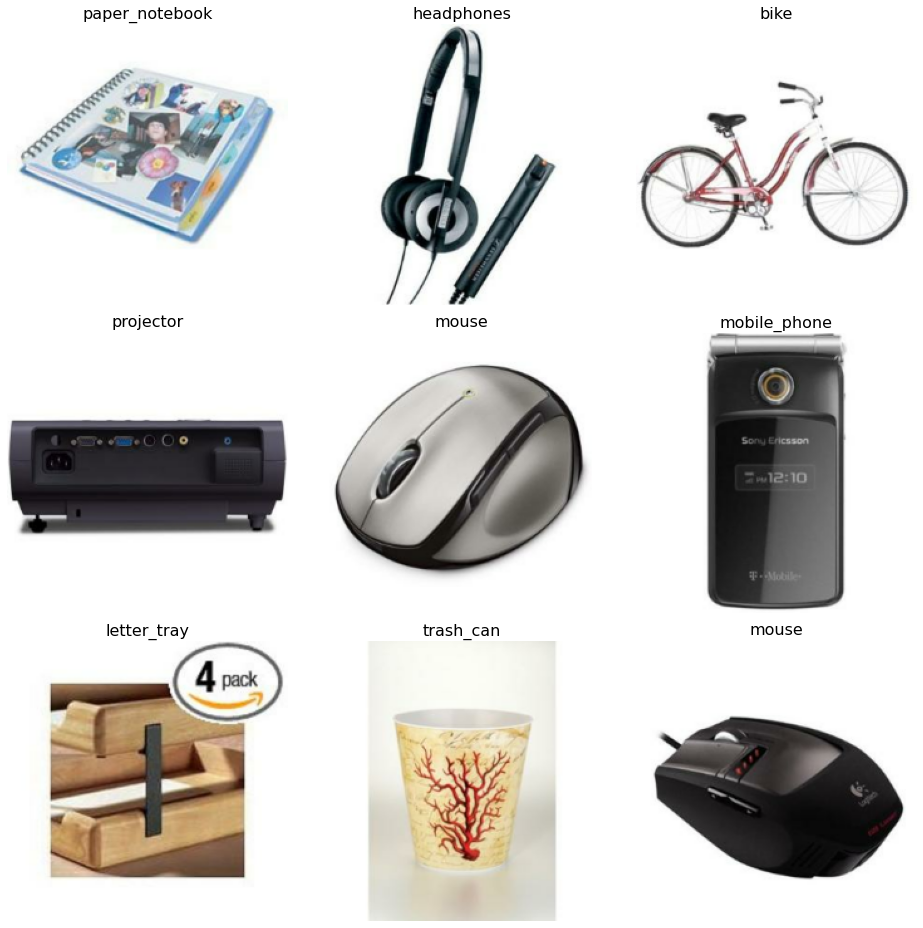

In [16]:
## Showing images in TFRecord file
a_filenames = tf.io.gfile.glob("./{}*.tfrec".format(DOMAIN))
a_dataset = tf.data.TFRecordDataset(a_filenames, num_parallel_reads=AUTO)
a_dataset = a_dataset.with_options(option_no_order)
a_dataset = a_dataset.map(lambda x: read_tfrecord(x, [224,224]), num_parallel_calls=AUTO)

display_dataset = a_dataset.map(lambda image, file_name, label_name, label: (image, label_name))
display_9_images_from_dataset(display_dataset)

### dslr

In [17]:
DOMAIN = 'dslr'
data_dir = Path('./dslr/images')
#!tree -d {str(data_dir)}

In [18]:
nb_images = len(tf.io.gfile.glob(str(Path(data_dir / '*/*.jpg')))) # 총 이미지 데이터 수 count
print (nb_images)

498


In [19]:
SHARDS = 1 # number of TFRecord that we will make
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

shard_size = math.ceil(1.0 * nb_images / SHARDS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

Pattern matches 498 images which will be rewritten as 1 .tfrec files containing 498 images each.


In [20]:
filenames = tf.data.Dataset.list_files(str(Path(data_dir / '*/*.jpg')), seed=35155) # This also shuffles the images
dataset = filenames.map(read_file_and_label, num_parallel_calls=AUTO)
dataset = dataset.batch(shard_size)

print("Writing TFRecords")
for shard, (bits, file_name, label_name, label) in enumerate(dataset):
  # batch size used as shard size here
  shard_size = bits.numpy().shape[0] 
  # good practice to have the number of records in the filename
  filename = './' + "{}-{:02d}-{}.tfrec".format(DOMAIN, shard, shard_size)
  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            bits.numpy()[i], 
                            file_name.numpy()[i],
                            label_name.numpy()[i],
                            label.numpy()[i]
                            )
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file ./dslr-00-498.tfrec containing 498 records


TFRecord 파일 Reading Test

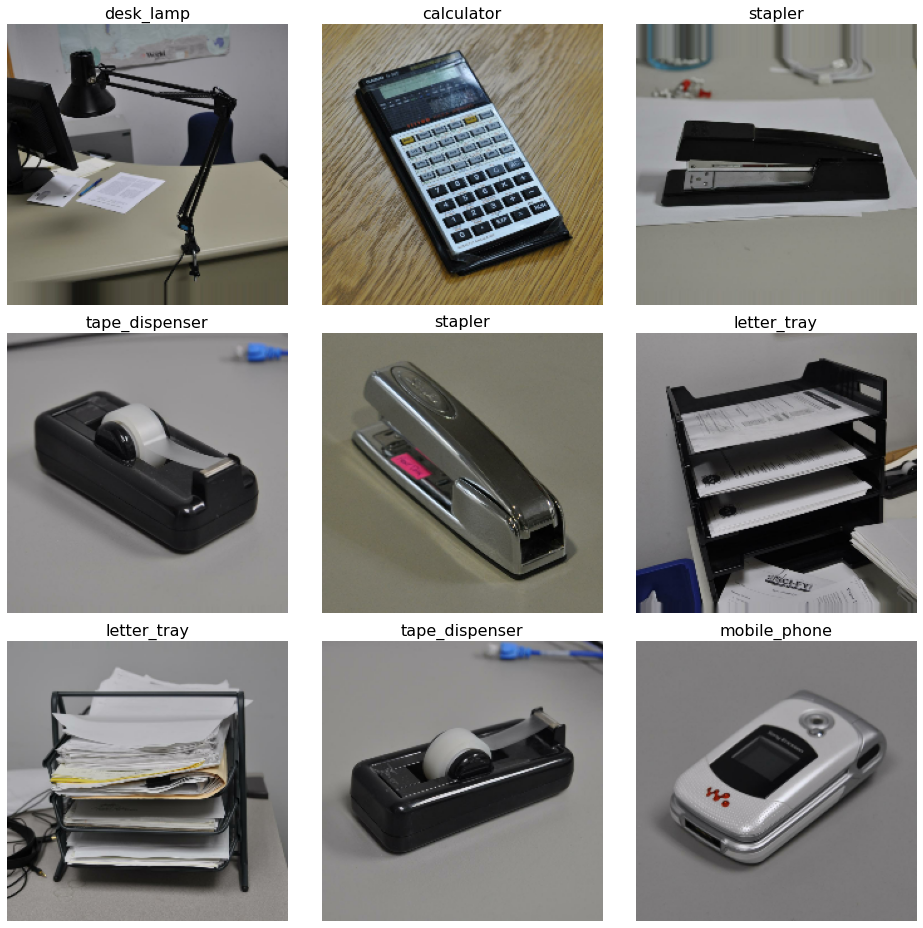

In [21]:
## Showing images in TFRecord file
a_filenames = tf.io.gfile.glob("./{}*.tfrec".format(DOMAIN))
a_dataset = tf.data.TFRecordDataset(a_filenames, num_parallel_reads=AUTO)
a_dataset = a_dataset.with_options(option_no_order)
a_dataset = a_dataset.map(lambda x: read_tfrecord(x, [224,224]), num_parallel_calls=AUTO)

display_dataset = a_dataset.map(lambda image, file_name, label_name, label: (image, label_name))
display_9_images_from_dataset(display_dataset)

### webcam

In [22]:
DOMAIN = 'webcam'
data_dir = Path('./{}/images'.format(DOMAIN))
#!tree -d {str(data_dir)}

In [23]:
nb_images = len(tf.io.gfile.glob(str(Path(data_dir / '*/*.jpg')))) # 총 이미지 데이터 수 count
print (nb_images)

795


In [24]:
SHARDS = 1 # number of TFRecord that we will make
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

shard_size = math.ceil(1.0 * nb_images / SHARDS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

Pattern matches 795 images which will be rewritten as 1 .tfrec files containing 795 images each.


In [25]:
filenames = tf.data.Dataset.list_files(str(Path(data_dir / '*/*.jpg')), seed=35155) # This also shuffles the images
dataset = filenames.map(read_file_and_label, num_parallel_calls=AUTO)
dataset = dataset.batch(shard_size)

print("Writing TFRecords")
for shard, (bits, file_name, label_name, label) in enumerate(dataset):
  # batch size used as shard size here
  shard_size = bits.numpy().shape[0] 
  # good practice to have the number of records in the filename
  filename = './' + "{}-{:02d}-{}.tfrec".format(DOMAIN, shard, shard_size)
  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            bits.numpy()[i], 
                            file_name.numpy()[i],
                            label_name.numpy()[i],
                            label.numpy()[i]
                            )
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file ./webcam-00-795.tfrec containing 795 records


TFRecord 파일 Reading Test

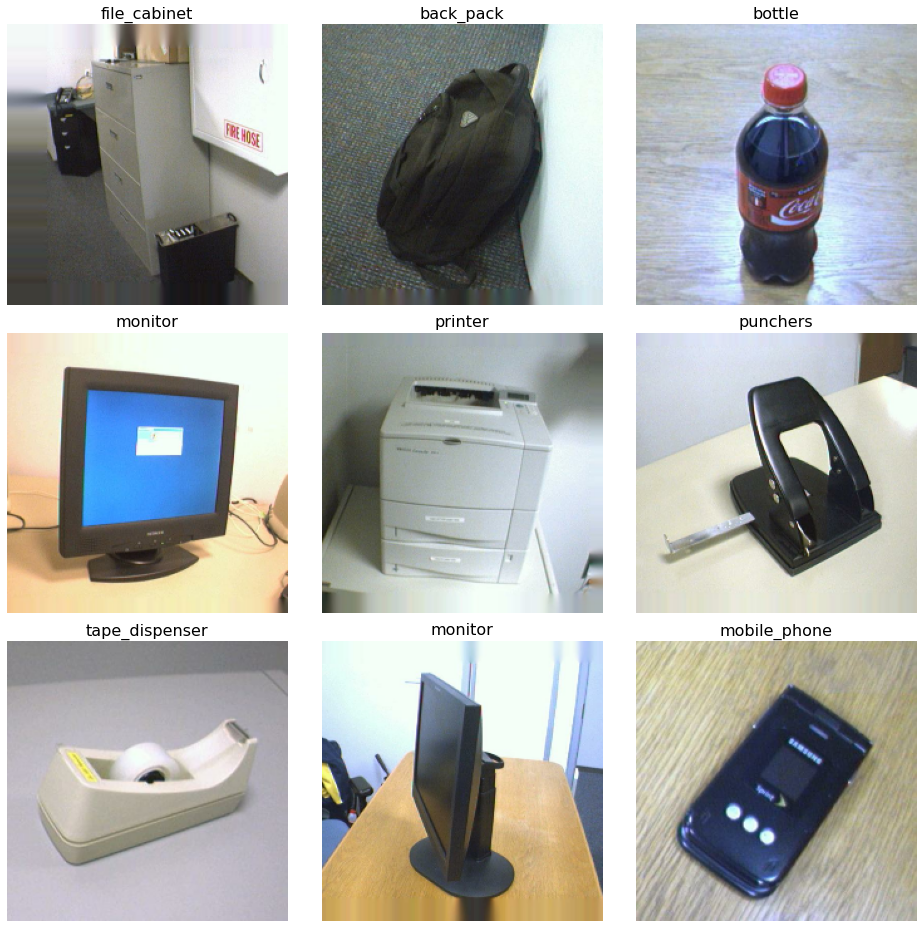

In [26]:
## Showing images in TFRecord file
a_filenames = tf.io.gfile.glob("./{}*.tfrec".format(DOMAIN))
a_dataset = tf.data.TFRecordDataset(a_filenames, num_parallel_reads=AUTO)
a_dataset = a_dataset.with_options(option_no_order)
a_dataset = a_dataset.map(lambda x: read_tfrecord(x, [224,224]), num_parallel_calls=AUTO)

display_dataset = a_dataset.map(lambda image, file_name, label_name, label: (image, label_name))
display_9_images_from_dataset(display_dataset)

In [27]:
ll

total 156528
drwxr-xr-x 3 root     4096 Mar 18 04:57 amazon/
-rw-r--r-- 1 root 24365355 Mar 18 04:58 amazon-00-2817.tfrec
-rw-r--r-- 1 root 77187046 Mar 18 04:57 domain_adaptation_images.tar.gz
drwxr-xr-x 3 root     4096 Mar 18 04:57 dslr/
-rw-r--r-- 1 root 37450804 Mar 18 04:58 dslr-00-498.tfrec
drwxr-xr-x 1 root     4096 Mar  5 14:37 sample_data/
drwxr-xr-x 3 root     4096 Mar 18 04:57 webcam/
-rw-r--r-- 1 root 21254986 Mar 18 04:58 webcam-00-795.tfrec


# Training

In [28]:
import re, sys, time
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.4.1


In [29]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])

elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)

else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

Running on single GPU  /physical_device:GPU:0


In [30]:
IMAGE_SIZE = [224, 224]
#CLASSES
EPOCHS = 100
BATCH_SIZE = 64
VALIDATION_BATCH_SIZE = 64
start_lr = 0.001
min_lr = 0.00001
max_lr = 0.005
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

0.001 1.000000387756711e-05


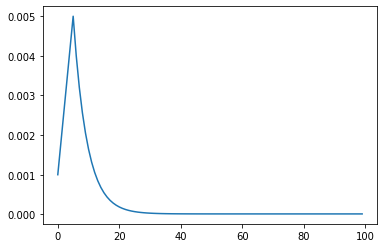

In [31]:
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [32]:
ll

total 156528
drwxr-xr-x 3 root     4096 Mar 18 04:57 amazon/
-rw-r--r-- 1 root 24365355 Mar 18 04:58 amazon-00-2817.tfrec
-rw-r--r-- 1 root 77187046 Mar 18 04:57 domain_adaptation_images.tar.gz
drwxr-xr-x 3 root     4096 Mar 18 04:57 dslr/
-rw-r--r-- 1 root 37450804 Mar 18 04:58 dslr-00-498.tfrec
drwxr-xr-x 1 root     4096 Mar  5 14:37 sample_data/
drwxr-xr-x 3 root     4096 Mar 18 04:57 webcam/
-rw-r--r-- 1 root 21254986 Mar 18 04:58 webcam-00-795.tfrec


In [33]:
# tfrecord이름에 포함된 파일 개수 counting하는 함수
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

TRAIN_FILENAMES = tf.io.gfile.glob('./amazon*.tfrec')
VALID_FILENAMES = tf.io.gfile.glob('./dslr*.tfrec')

# Keras로 학습할 때 필요한 train_steps 계산
TRAIN_STEPS = count_data_items(TRAIN_FILENAMES) // BATCH_SIZE
print("TRAINING IMAGES: ", count_data_items(TRAIN_FILENAMES), ", STEPS PER EPOCH: ", TRAIN_STEPS)
print("VALIDATION IMAGES: ", count_data_items(VALID_FILENAMES))

TRAINING IMAGES:  2817 , STEPS PER EPOCH:  44
VALIDATION IMAGES:  498


## training and validation datasets

TFRecord 파일 기반 DataSet 생성

In [34]:
## TFRecord 파일 Parsing 
#### TFRecord 생성 코드 참고해서 정의함
#### TFRecord에 포함된 데이터들 중 필요한 것들만 Return

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32) ## make [0,255] to [0,1) resize 앞에 위치할 때만 [0,1), 즉 input이 float32가 아니어야 작동
    image = tf.image.resize(image, IMAGE_SIZE) ## method가 tf.image.ResizeMethod.NEAREST_NEIGHBOR 가 아니면 출력은 무조건 float32

    class_label = tf.cast(example['label'], tf.int32)
    #one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    #one_hot_class = tf.reshape(one_hot_class, [31])
    one_hot_class = tf.one_hot(class_label, 31)
    return image, one_hot_class
  
def force_image_sizes(dataset, image_size):
    # explicit size will be needed for TPU
    reshape_images = lambda image, label: (tf.reshape(image, [*image_size, 3]), label)
    dataset = dataset.map(reshape_images, num_parallel_calls=AUTO)
    return dataset

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
    # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.

    opt = tf.data.Options()
    opt.experimental_deterministic = False

    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.with_options(opt)
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    #dataset = force_image_sizes(dataset, IMAGE_SIZE)
    return dataset

def data_augment(image, one_hot_class):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, one_hot_class

def make_NCHW(image, one_hot_class):
    image = tf.transpose(image, [2, 0, 1]) # HWC -> CHW
    return image, one_hot_class  

def get_training_dataset():
    dataset = load_dataset(TRAIN_FILENAMES)
    #dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    #dataset = dataset.map(make_NCHW, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(VALID_FILENAMES)
    #dataset = dataset.map(make_NCHW, num_parallel_calls=AUTO)
    dataset = dataset.batch(VALIDATION_BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    
    # needed for TPU 32-core pod: the test dataset has only 3 files but there are 4 TPUs. FILE sharding policy must be disabled.
    opt = tf.data.Options()
    opt.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    dataset = dataset.with_options(opt)
    
    return dataset

In [35]:
training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

In [36]:
def create_model():
    pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = True
    
    x = pretrained_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='softmax', name='feature') (x)  
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)  
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    predictions = tf.keras.layers.Dense(31, activation='softmax', name='prediction') (x)
    model = tf.keras.Model(inputs=pretrained_model.input, outputs=predictions)
    
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [37]:
with strategy.scope(): # creating the model in the TPUStrategy scope places the model on the TPU
    model = create_model()
model.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

In [39]:
import os 

model_dir = './'
ckpt_full_path = os.path.join(model_dir, 'model.ckpt-{epoch:04d}')
callbacks = [
    lr_callback,
    tf.keras.callbacks.TensorBoard(log_dir = model_dir),
    #tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_full_path,
    #                                   save_weights_only=True),
]

In [ ]:
print ('BATCH_SIZE: ', BATCH_SIZE)
start_time = time.time()
history = model.fit(training_dataset, validation_data=validation_dataset,
                    steps_per_epoch=TRAIN_STEPS, epochs=EPOCHS, callbacks=callbacks)
#history = model.fit(training_dataset, validation_data=validation_dataset,
#                    steps_per_epoch=TRAIN_STEPS, epochs=EPOCHS, callbacks=[lr_callback])

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

BATCH_SIZE:  64
Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
44/44 [==============================] - 74s 788ms/step - loss: 3.1631 - accuracy: 0.2017 - val_loss: 3.4349 - val_accuracy: 0.0281
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0018.
44/44 [==============================] - 30s 687ms/step - loss: 2.8376 - accuracy: 0.2821 - val_loss: 3.4644 - val_accuracy: 0.0201
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0026.
44/44 [==============================] - 30s 695ms/step - loss: 2.6849 - accuracy: 0.2835 - val_loss: 3.4604 - val_accuracy: 0.0522
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0034000000000000002.
44/44 [==============================] - 31s 697ms/step - loss: 2.6196 - accuracy: 0.3046 - val_loss: 3.4982 - val_accuracy: 0.0422
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 0.004200000000000001.
44/44 [===========

In [1]:
save_model = create_model()
save_model.set_weights(model.get_weights())
save_model.save('office31_resnet50.h5')

NameError: ignored

In [ ]:
from google.colab import files

files.download('office31_resnet50.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>